# Лабораторная работа №1

## Часть 1. Выполнил Филенков Алексей Дмитриевич

### Загрузка и изучение первой таблицы

Imports

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")

Чтение данных за июль

In [2]:
df_july = pd.read_excel("database/July.xls",'платные всего',skiprows=(0,1,2,3,4,5))
df_july.columns = ("Place","In Fact","Previous month %","The same month prev year %")
df_july

,Place,In Fact,Previous month %,The same month prev year %
0,Россия,1.453865e+09,100.2,103.1
1,Центральный федеральный округ,5.422813e+08,100.6,103.0
2,Белгородская область,9.503504e+06,98.3,101.6
3,Брянская область,6.273764e+06,98.8,96.9
4,Владимирская область,8.077065e+06,96.4,97.1
...,...,...,...,...
91,Амурская область,5.658658e+06,96.2,104.0
92,Магаданская область,1.419946e+06,97.9,102.9
93,Сахалинская область,4.806984e+06,94.6,99.8
94,Еврейская автономная область,9.670283e+05,96.7,102.3


Данные представляют из себя таблицу доходов от платных услуг по месяцам для определённых областей и округов

Разделим данные на 2 выборки:
1) Округа
2) Области

Так как у них разные порядки дохода

In [3]:
areas = df_july['Place'].apply(lambda data: True if 'федеральный округ' in data else False)
areas.iloc[0] = True
areas
# Россия + агрегирующие строки по округам
df_july[areas]

# Все остальные (области)
df_july[~areas]

# Добавим данные о месяце
df_july["month"] = "July"
df_july

,Place,In Fact,Previous month %,The same month prev year %,month
0,Россия,1.453865e+09,100.2,103.1,July
1,Центральный федеральный округ,5.422813e+08,100.6,103.0,July
2,Белгородская область,9.503504e+06,98.3,101.6,July
3,Брянская область,6.273764e+06,98.8,96.9,July
4,Владимирская область,8.077065e+06,96.4,97.1,July
...,...,...,...,...,...
91,Амурская область,5.658658e+06,96.2,104.0,July
92,Магаданская область,1.419946e+06,97.9,102.9,July
93,Сахалинская область,4.806984e+06,94.6,99.8,July
94,Еврейская автономная область,9.670283e+05,96.7,102.3,July


Превратим обработку одной таблицы в функцию и соберём данные за 2024 год

In [4]:
def preprocess_table(df,month):
    '''
    Функция разбиения на 2 таблицы с добавлением информации о месяце.
    '''
    areas = df['Place'].apply(lambda data: True if 'федеральный округ' in data else False)
    areas.iloc[0] = True
    areas
    # Россия + агрегирующие строки по округам
    df_districts = df[areas]

    # Все остальные
    df_areas = df[~areas]

    # Добавим данные о месяце
    df_districts["month"] = month
    df_areas["month"] = month
    return df_districts, df_areas

list_of_months = ["April","February","January","July","June","March","May"]
print(f"Count of months: {len(list_of_months)}")

full_df_districts = pd.DataFrame()
full_df_areas = pd.DataFrame()
for month in list_of_months:
    df = pd.read_excel(f"database/{month}.xls",'платные всего',skiprows=(0,1,2,3,4,5))
    df.columns = ("Place","In Fact","Previous month %","The same month prev year %")
    # Разбиваем таблицу на две
    df_districts, df_areas = preprocess_table(df,month)
    
    # Конкатенируем все данные в одну таблицу
    if full_df_areas.shape:
        full_df_areas = pd.concat([full_df_areas,df_areas],axis=0)
    else:
        full_df_areas = df_areas

    if full_df_districts.shape:
        full_df_districts = pd.concat([full_df_districts,df_districts],axis=0)
    else:
        full_df_districts = df_districts
    

Count of months: 7


### Узнаем параметры данных за 2024 год
1) Среднее
2) Медиану
3) Среднеквадратичное отклонение

In [10]:
# Параметры для областей
max_areas = int(full_df_areas["In Fact"].max())
mean_areas = int(full_df_areas["In Fact"].mean())
median_areas = int(full_df_areas["In Fact"].median())
var_areas = int(full_df_areas["In Fact"].std())
print(f"Areas max: {max_areas}, mean: {mean_areas} руб, median:{median_areas} руб, std:{var_areas} руб")

# Параметры для округов
max_districts = int(full_df_districts["In Fact"].max())
mean_districts = int(full_df_districts["In Fact"].mean())
median_districts = int(full_df_districts["In Fact"].median())
var_districts = int(full_df_districts["In Fact"].std())
print(f"Districts max: {max_districts}, mean: {mean_districts} руб, median:{median_districts} руб, std:{var_districts} руб")

Areas max: 353112172, mean: 16440173 руб, median:7590958 руб, std:36807408 руб
Districts max: 1453864854, mean: 307581984 руб, median:141982059 руб, std:405556451 руб


### Агрегируем по месту (топ 10)

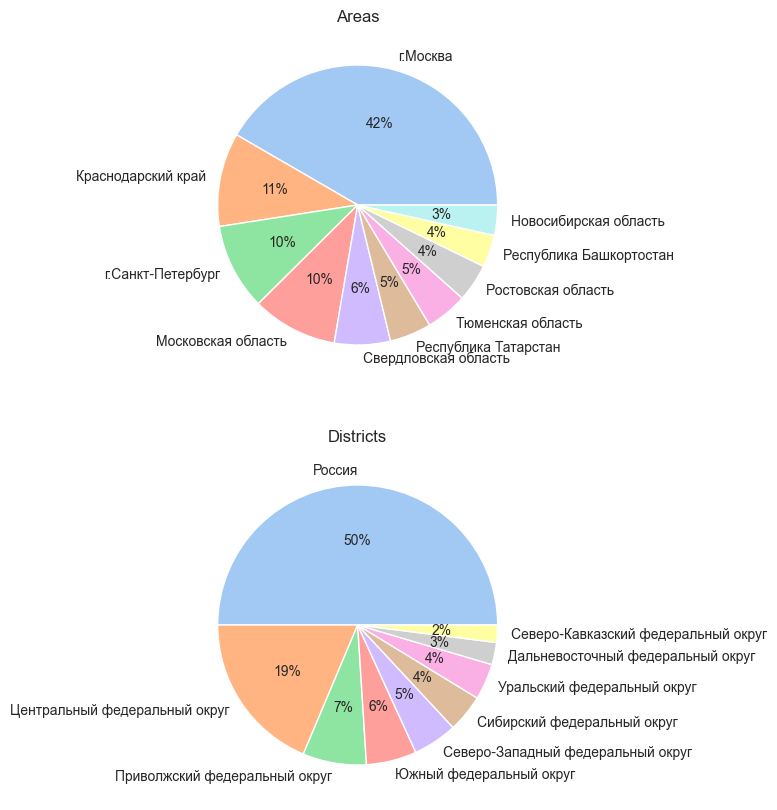

In [11]:
X1 = full_df_areas.drop(columns=['month']).groupby(by="Place").mean()
X1 = X1.sort_values(by="In Fact",ascending=False).head(10)

X2 = full_df_districts.drop(columns=['month']).groupby(by="Place").mean()
X2 = X2.sort_values(by="In Fact",ascending=False).head(10)

# Столбчатая диаграмма
# plt.figure(figsize=(20,5),dpi=200)
# plt.xticks(rotation=45)
# sns.barplot(data=X1, x="Place", y="In Fact")

# Круговая диаграмма
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
plt.title("Areas")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X1["In Fact"], labels = X1.index, colors = colors, autopct='%.0f%%')

plt.subplot(2, 2, 3)
plt.title("Districts")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X2["In Fact"], labels = X2.index, colors = colors, autopct='%.0f%%')
plt.show()

Вывод: Видно, что Москва и как следствие Центральный федеральный округ получают наибольшее кол-во средств за платные услуги

Агрегируем данные платных услуг по месяцам

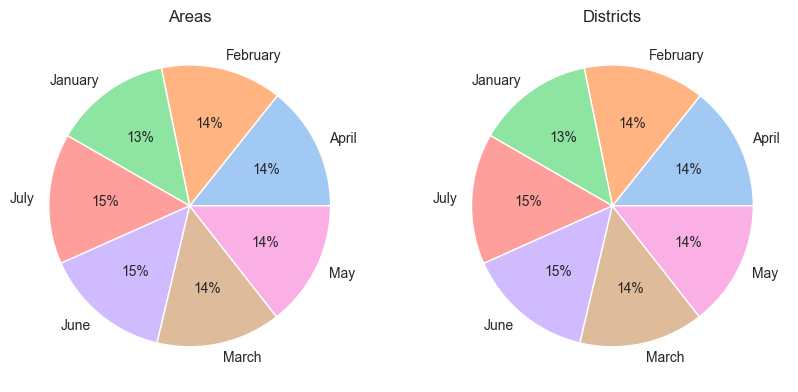

In [12]:
X1 = full_df_areas[["In Fact","Previous month %","The same month prev year %","month"]].groupby(by="month").mean()
X2 = full_df_districts[["In Fact","Previous month %","The same month prev year %","month"]].groupby(by="month").mean()

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title("Areas")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X1["In Fact"], labels = X1.index, colors = colors, autopct='%.0f%%')

plt.subplot(1, 2, 2)
plt.title("Districts")
colors = sns.color_palette('pastel')[ 0:10 ]
plt.pie(X2["In Fact"], labels = X2.index, colors = colors, autopct='%.0f%%')
plt.show()

Полученный доход распределён равномерно по месяцам

### Посмотрим распределение доходов

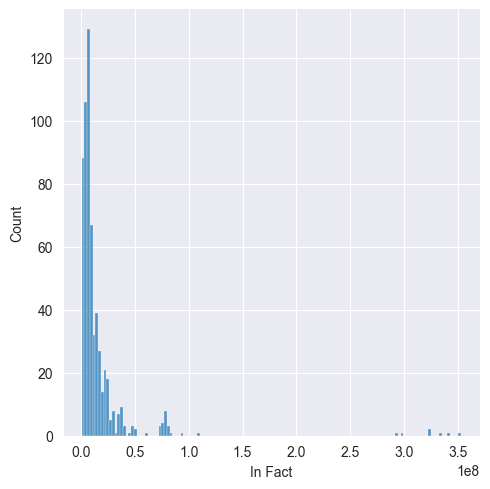

In [66]:
X1 = full_df_areas["In Fact"]
sns.displot(X1)
plt.show()

Это ассимитричное распределение с смещенным средним. Попробуем преобразовать его с нормальному симметричному виду.

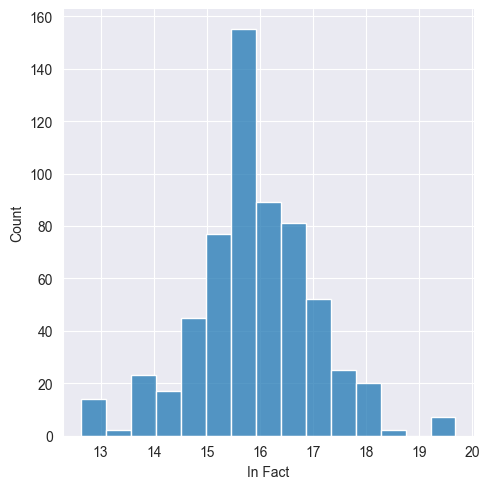

In [70]:
X1 = np.log(full_df_areas["In Fact"])
sns.displot(X1,bins=15)
plt.show()

Это уже больше похоже на нормальное распределение.

Удалим выбросы

<Axes: ylabel='In Fact'>

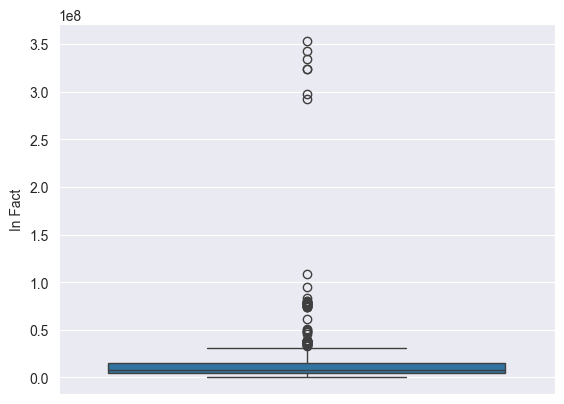

In [14]:
sns.boxplot(X1)

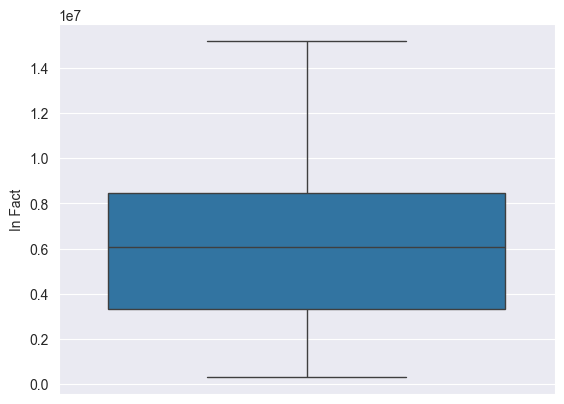

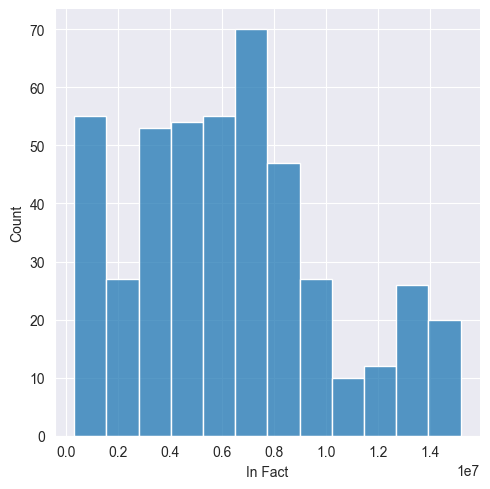

In [28]:
X1_clear = X1[X1 < X1.quantile(0.75)]
sns.boxplot(X1_clear)
sns.displot(X1_clear)
plt.show()

Видно, что данное распределение со смещённым средним и оно ассиметрично относительно нормального.